# Проект  " Телекоммуникации"

**Описание проекта**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

Оператор предоставляет два основных типа услуг: 
 - Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
 - Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
 - Также доступны такие услуги:
   - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
   - Выделенная линия технической поддержки (TechSupport);
   - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
   - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

***Описание данных***

Данные состоят из нескольких файлов, полученных из разных источников:
 - contract_new.csv — информация о договоре;
 - personal_new.csv — персональные данные клиента;
 - internet_new.csv — информация об интернет-услугах;
 - phone_new.csv — информация об услугах телефонии.sv.

***Задача***:
- обучить на предоставленных выше данных модель для прогноза оттока клиентов. Основная метрика: AUC-ROC. Дополнительная метрика: Accuracy.Критерии оценки: AUC-ROC >= 0.85


In [1]:
#установим некоторые доп библиотеки
!pip install scikit-learn==1.1.3 -q
!pip install phik -q
!pip install matplotlib==3.5.2 -q
!pip3 install imblearn -q

In [2]:
#импортируем необходимые библиотеки 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import sklearn
import datetime
import os 
import re
import time
from scipy import stats as st
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import make_scorer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler,\
LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,precision_score, recall_score,confusion_matrix, \
    ConfusionMatrixDisplay

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier # CatBoost (Яндекс).
from sklearn.utils.class_weight import compute_class_weight

#зададим формат вывода знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Отображение всех столбцов таблицы
pd.set_option('display.max_columns', None)

In [3]:
#константа для фиксации случайных значений
RANDOM_STATE = 80724

## Загрузка данных

Вынесем все функции, написанные для данного проекта,в одном месте.


Функции для предобработки

In [4]:
# функция загрузки данных из файлов
def download(file):
    
    data = pd.DataFrame()
    
    path_1 = '/datasets/' + file + '.csv'
    path_2 = 'https://code.s3.yandex.net/datasets/' + file + '.csv'
    
    if os.path.exists(path_1):
        data = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2)
    
    return data


#функция для приведения названий столбцов к "змеиному регистру".
def rename(file):
    #заглавные буквы поменяем на строчные и в месте перед ранее стоявшей заглавной буквой поставим нижний прочерк
    file.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in file.columns]
    #в двух столбцах прочерка будет 2, нужно убрать 1 из них
    file = file.rename(columns={'customer_i_d':'customer_id','streaming_t_v':'streaming_tv'})
    return file 


#функция, которая выводит уникальные значения в категориальных данных
def unique(file):
    for column in file.drop(['customer_id'],axis=1).select_dtypes(exclude='number'):
        print (column,':')
        print (file.select_dtypes(exclude='number')[column].unique(),'\n')
        

#функция для проверки дубликатов
def duplicates_count(file):
    print('Кол-во полных дубликатов:',file.duplicated().sum(),'\nКол-во дубликатов ID пользователя:',\
      file["customer_id"].duplicated().sum())  

Функции для построения графиков

In [5]:
#функция для построения круговой диаграммы
def pie(df,column):
    df_1 = df.pivot_table(index=column,values='target',aggfunc='count').reset_index()
    plt.pie(df_1['target'], autopct='%.1f%%', radius=1);
    plt.legend(labels=df_1[column],loc='upper left', bbox_to_anchor=(1.5, 1.0));
    plt.title('Распределение пользователей по значению '+column,fontsize=14)
    plt.show()
    

#функция для построения гистограммы распределения и диаграммы размаха
def hist_box(df,column):
    fig, ax = plt.subplots(figsize = (9, 6));
    ax = plt.subplot(2,1,1)
    
    df.plot(kind='hist',y=column,histtype='step',bins=100,linewidth=2,alpha=0.5,ax=ax);
    plt.ylabel('Кол-во пользователей', fontsize=12);
    plt.title('Гистограмма и диаграмма распределения пользователей по значению '+column,fontsize=14);

    sns.boxplot(df[column], ax = plt.subplot(2,1,2));
    plt.xlabel(column, fontsize=12);
    

#функция для построения круговой диаграммы для 2-х датафреймов в один ряд
def pie_1(df_1,df_2,column):
    df_1=df_1.pivot_table(index=column,values='target',aggfunc='count').reset_index()
    df_2=df_2.pivot_table(index=column,values='target',aggfunc='count').reset_index()
    
    fig, ax = plt.subplots(figsize = (20, 5))
    
    ax = plt.subplot(1, 2, 1)
    plt.pie(df_1['target'], autopct='%.1f%%', radius=0.75);
    plt.xlabel('Распределение по активным договорам', fontsize=12);
    plt.legend(labels=df_1[column],loc='upper left', bbox_to_anchor=(1.5, 1.0));

    ax = plt.subplot(1, 2, 2)
    plt.pie(df_2['target'],autopct='%.1f%%', radius=0.75);
    
    plt.xlabel('Распределение по закрытым договорам', fontsize=12);
    #plt.legend(labels = df_2[column],loc='upper left', bbox_to_anchor=(1.0, 1.0));
    
    fig.suptitle('Распределение клиентов по значению '+column,fontsize=14)
    plt.subplots_adjust(wspace=1,hspace = 1)
    plt.show()  
    
    
#функция для построения 2-х гистограмм на одном графике с нормализацией по плотности 
def hist(df,column):
    fig, ax = plt.subplots(figsize = (12, 6));
    ax = plt.subplot()
    
    df.query('target=="closed"').plot(kind='hist',y=column,label = 'closed',\
                                      histtype='step',bins=100,linewidth=2,alpha=0.5,ax=ax,density = True);
    df.query('target=="active"').plot(kind='hist',y=column,label = 'active',\
                                      histtype='step',bins=100,linewidth=2,alpha=0.5,ax=ax,density = True);
    plt.legend()
    plt.grid(True)
    plt.ylabel('Доля пользователей', fontsize=12);
    plt.xlabel(column, fontsize=12);
    plt.title('Гистограмма  распределения пользователей по значению '+column,fontsize=14);
    plt.show()
    
    
#функция для построения боксплота в разрезе таргета
def boxplot(df, column):
    df.boxplot(column, by='target', figsize=(5,5))
    plt.ylabel(column, fontsize=12);
    plt.xlabel(' ', fontsize=12);
    plt.title('Диаграмма размаха  в разрезе активный/закрытый договор по значению '+column);    

Функция для обучения моделей с поиском гиперпараметров лучшей модели через метрику  кросс-валидацией

In [6]:
#функция для обучения моделей с поиском гиперпараметров лучшей модели через метрику  кросс-валидацией
def training(model, parameters, boosting = True):    

    grid = GridSearchCV(
        model,
        parameters,
        #verbose=3,
        cv=5,
        n_jobs=-1,
        error_score='raise',
        scoring='roc_auc'
    )
    
    if boosting:
        grid.fit(X_boost_train,y_boost_train,cat_features = cat_col)
    else:
        grid.fit(X_train,y_train)
     
    
    print(f'Значение AUC-ROC на кросс-валидации: {round(grid.best_score_, 2)}')
    print(grid.best_params_)
    print(f'Время на обучение модели- {round(grid.refit_time_,2)} секунд')
    return grid

Далее загрузим данные и проведем их первичный осмотр

In [7]:
# выгрузим информацию о договорах
contract = download('contract_new')

#выведем любые 5 строк
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
700,1525-LNLOJ,2014-08-01,2018-07-01,Two year,Yes,Bank transfer (automatic),63.30,3183.36
4883,5233-GEEAX,2019-02-01,No,Month-to-month,Yes,Electronic check,29.40,356.33
691,6663-JOCQO,2017-07-01,No,One year,Yes,Bank transfer (automatic),75.25,2542.7
6895,5126-RCXYW,2015-08-01,2019-10-01,Two year,No,Credit card (automatic),46.00,2300.0
2225,1153-GNOLC,2017-05-01,No,One year,Yes,Electronic check,39.10,1290.3


In [8]:
# выгрузим информацию о персональных данных клиента
personal = download('personal_new')

#выведем любые 5 строк
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
2704,9640-ZSLDC,Female,0,Yes,Yes
4315,9019-QVLZD,Female,0,No,No
1302,3230-IUALN,Female,0,Yes,Yes
5894,7881-INRLC,Male,0,No,No
2163,4021-RQSNY,Male,1,Yes,No


In [9]:
# выгрузим информацию об интернет-услугах
internet = download('internet_new')

#выведем любые 5 строк
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2471,7410-KTVFV,DSL,No,No,Yes,No,No,No
1386,3658-QQJYD,DSL,Yes,Yes,No,No,Yes,Yes
2374,5897-ZYEKH,Fiber optic,Yes,Yes,No,No,Yes,Yes
1743,5494-WOZRZ,DSL,Yes,No,Yes,Yes,Yes,Yes
3889,1862-SKORY,DSL,No,Yes,No,No,Yes,No


In [10]:
# выгрузим информацию об услугах телефонии
phone = download('phone_new')

#выведем любые 5 строк
phone.sample(5)

,customerID,MultipleLines
4269,0594-UFTUL,No
4391,3389-YGYAI,Yes
4330,7594-LZNWR,No
2572,3251-YMVWZ,Yes
6054,8080-POTJR,Yes


Данные из всех файлов выгружены

## Исследовательский анализ и предобработка данных

### Данные с информацией о договорах

In [11]:
#приведем названия столбцов к "змеиному регистру"
contract = rename(contract)
#выведем общую информацию и заодно посмотрим типы данных  столбцы
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Данные представлены 7043 строками и 8-ю столбцами, явные пропуски отсутствуют.

Некорректные типы данных у следующих столбцов:
 - BeginDate: тип данных должен быть дата,
 - EndDate:тип данных должен быть дата,
 - TotalCharges: должен быть числовой.
 
 Определим, по какой причине тип указанных выше столбцов некорректный (например, при смешении типов данных в столбце, итоговый тип данных будет определяться как  object.
 
Выведем перечень уникальных значений всех нечисловых столбцов 

In [12]:
#применим функцию к данным с контрактами
unique(contract)

begin_date :
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-01' '2013-11-01' '2014-01-0

 - Визуальный анализ некорректности в датах не выявил ( в т.ч. невозможные года - позднее 2020, нереальные года), поэтому просто изменим формат типа данных,
 - Визуальный анализ некорректности в датах не выявил ( в т.ч. невозможные года - позднее 2020, нереальные года). Дата окончания действия договора кроме дат имеет строковое значение No, которое подразумевает, что договор еще действующий
 - Общие расходы имеют очень много уникальных значений, среди которых затерялся какой-то иной тип данных (скорее всего строковой) - пробел, слова в нижнем/верхнем регистре, также возможно целую и дробную часть чисел разделяет запятая, а не точка и из-за этого числовой тип данных не определяется. Проверим

In [13]:
#выведем данные в столбце с общими расходами, в котором могут быть строковые значения, пробел или запятая
contract.loc[
    contract['total_charges'].str.contains(' |,|[a-z]|[A-Z]'), 
    'total_charges'
].unique()

array([' '], dtype=object)

Итак, чисел с разделителем целой и дробной части запятой/слов нет, но есть неявные пропуски в виде пробела. Посмотрим, в каком случае присутствуют данные неявные пропуски

In [14]:
contract.loc[contract['total_charges']==' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Данные пробелы совпадают с датой начала договора 2020-02-01	, что соответствует дате выгрузки отчета, т.е. это новые клиенты и расходов еще попросту нет. Заменим пробел в общих расходах  на значение 0.

Сгенерируем целевой признак из столбца с датой окончания договора: если дата указан - договор закрыт, если  No = еще активный.

Также заменим значение No в столбце с датой окончания контракта на дату выгрузки, чтобы в этом столбце были даты - в последующем сами по себе признаки с датами будут не нужны, поскольку при более поздних датах модель попросту не сможет их отработать.

Также изменим тип данных 3-х столбцов и проверим результат

In [15]:
#создадим столбец с признаком закрытого договора
contract['target'] = contract['end_date'].apply(lambda x: 'closed' if x!="No" else 'active')

In [16]:
#сделаем замену значения пробел столбца с общими расходами и значения No в столбце с датой окончания
contract.loc[contract['total_charges']==' ', 'total_charges'] = 0
contract.loc[contract['end_date']=='No', 'end_date'] = '2020-02-01'
#поменяем тип данных
contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['end_date'] = pd.to_datetime(contract['end_date'])
contract['total_charges'] = contract['total_charges'].astype('float')
#выведем инфо о таблице для проверки типа столбца
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   target             7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 495.3+ KB


Итак, тип данных корректный.

Проверим данные на явные дубликаты, также отдельно на дубликаты индентификаторов пользователей(данные остальных столбцов в целом могут совпадать).

In [17]:
#проверим на дубликаты
duplicates_count(contract) 

Кол-во полных дубликатов: 0 
Кол-во дубликатов ID пользователя: 0


Дубликаты отсутствуют.

Оценим сезонность  в открытии/закрытии договоров в разрезе месяца и дня, а также в датах открытия всех договоров и тех, которые были закрыты  впоследствии.

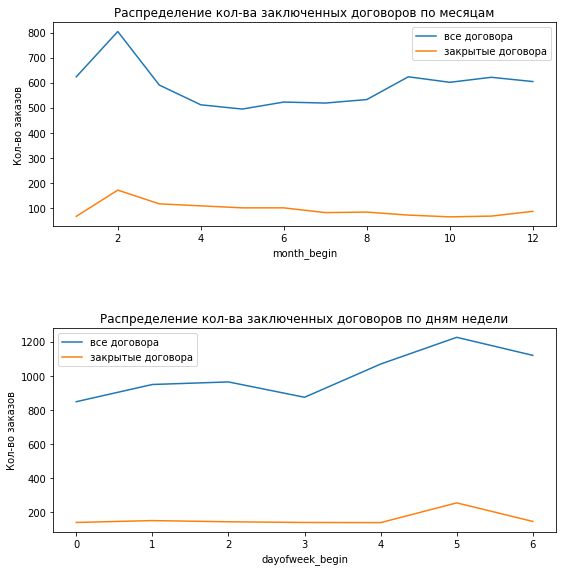

In [18]:
#создадим признаки с годом, месяцем и днем недели
contract['dayofweek_begin'] = pd.to_datetime(contract['begin_date']).dt.dayofweek
contract['month_begin'] = pd.to_datetime(contract['begin_date']).dt.month

#Построим графики количества заказов
plt.figure(figsize=(9,15))
plt.subplot(3,1,1)
contract.groupby('month_begin')['month_begin'].count().plot(label='все договора');
contract.query('end_date!="2020-02-01"').groupby('month_begin')['month_begin'].count().plot(label='закрытые договора');
plt.title('Распределение кол-ва заключенных договоров по месяцам');
plt.ylabel('Кол-во заказов');
plt.legend();
plt.subplots_adjust(wspace=0.5,hspace = 0.5);
plt.subplot(3,1,2)
contract.groupby('dayofweek_begin')['dayofweek_begin'].count().plot(label='все договора');
contract.query('end_date!="2020-02-01"').groupby('dayofweek_begin')['dayofweek_begin'].count().plot(label='закрытые договора');
plt.title('Распределение кол-ва заключенных договоров по дням недели');
plt.ylabel('Кол-во заказов');
plt.legend();

Сезонность кол-ва открытых договоров по месяцам и дням недели как оиждаемо присутствует и объяснимо:
 - по месяцам: из данных выбивается февраль - по статистике чаще всего меняют поставщика услуг/страховыет и пр. аналогичные службы в начале календарного года, далее где-то в течение месяца договора разрываются и, соответственно, заключаются договора с новыми поставщиками услуг, далее в весенне-летний период некоторое охлаждение рынка. График заключения закрытых впоследствии договоров повторяет зависимости,выявленные по всем договорам в целом, т.е. месяц заключения договора не влияет на вероятность того, что договор будет закрыт,
 - по дню недели: наблюдается увеличение кол-ва заключенных договоров с пятницы по воскресенье с пиком в субботу, далее снижение в понедельник-четверг. По закрытым впоследствии договорам зависимость аналогичная.
 
Т.о. нельзя утверждать,что месяц/день недели заключения договора существенно влияет на вероятность того,что он впоследствии будет закрыт и данный признак ( в части месяца/дня недели) для обучения модели не нужен. По совокупности для модели не нужен признак как полной даты заключения контракта (поскольку могут подаваться даты, которых при обучении не было),так и ее составляющих.

Оценим сезонность кол-ва закрытия договоров в разрезе месяца/дня недели

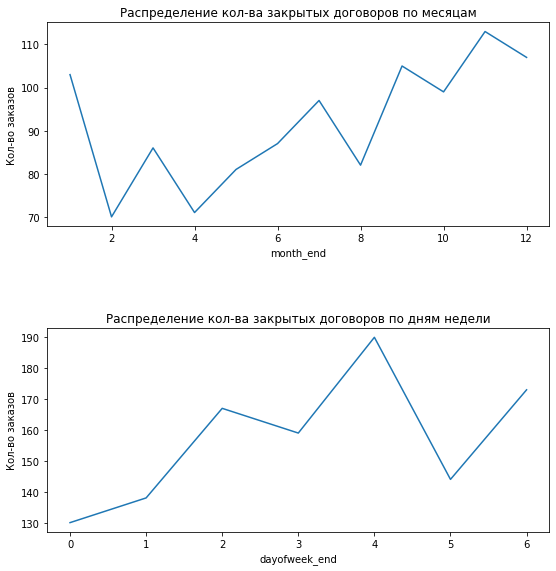

In [19]:
contract['dayofweek_end'] = pd.to_datetime(contract['end_date']).dt.dayofweek
contract['month_end'] = pd.to_datetime(contract['end_date']).dt.month

#Построим графики количества заказов
plt.figure(figsize=(9,15))
plt.subplot(3,1,1)
contract.query('end_date!="2020-02-01"').groupby('month_end')['month_end'].count().plot();
plt.title('Распределение кол-ва закрытых договоров по месяцам');
plt.ylabel('Кол-во заказов');
plt.subplots_adjust(wspace=0.5,hspace = 0.5);
plt.subplot(3,1,2)
contract.query('end_date!="2020-02-01"').groupby('dayofweek_end')['dayofweek_end'].count().plot();
plt.title('Распределение кол-ва закрытых договоров по дням недели');
plt.ylabel('Кол-во заказов');

Закрывать договора клиенты более склонны осенью и пик приходится на конец календарного года -именно в это время стоит более активно предлагать промокоды и спецусловия клиентам с высоким риском разрыва контракта. Что касается дня неделит разрыва - пик приходится на пятницу.

Как мы выяснили выше, даты открытия/закрытия контрактов не целесообразно использовать для построения модели, поэтому удалим их. При это важным фактором может оказаться такой показатель как длительность договора ( к моменту закрытия либо если он действующий, то к моменту выгрузки данных 1 февраля 2020), поэтому перед удалением создадим новыйт признак "длительностьт контракта"/"duration". Одновременно проверим даты (чтобы дата закрытия не была раньше даты заключения)

In [20]:
#создадим столбец с длительностью контракта в днях,одновременно проверив корректность дат - отрицательных значений 
#длительности быть не должно 
contract['duration'] = (contract['end_date'] - contract['begin_date']).dt.components.days
contract.query('duration<0')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,dayofweek_begin,month_begin,dayofweek_end,month_end,duration


Некорректных значений с датами не было - косвенно проверили, что показатель длительности договора корректный.

In [21]:
#удалим ненужные для модели столбцы с датами заключения и разрыва договоров, а также созданные для анализа столбцы
contract = contract.drop(['begin_date','end_date','dayofweek_begin','dayofweek_end','month_begin','month_end'],axis=1)

#выведем размер нашей новой таблицы и столбцы
print(f'Размер новой таблицы:\n{contract.shape},\n\nСтолбцы новой таблицы:\n{contract.columns.to_list()}')

Размер новой таблицы:
(7043, 8),

Столбцы новой таблицы:
['customer_id', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'target', 'duration']


**Вывод по анализу и предобработке**:

 - входные данные были представлены 7043 строками и 8 столбцами,
 - явные пропуски отсутствовали, при этом в рамках анализа выявлены неявные пропуски в столбце с общими расходами в виде пробелов:заполнены нулями, т.к. эти пропуски совпадают с датой выгрузки данных - платежей еще не было,
 - явные/неявные дубликаты отсутствуют,
 - у столбцов с датами и общими расходами были некорректные типы данных, которые были приведены в соответствие: в столбце с датой закрытия помимо дат было указано строковое значение No (договор не расторгнут), которое было заменено на дату выгрузки данных(1 февраля 2020), в столбце с общими расходами также были строковые значения в виде пробела (заполнен нулями - см.выше),
 - анализ дат заключения и разрыва контракта, в т.ч. в разрезе месяцев и дней недели показал, что:
   - Сезонность кол-ва открытых договоров/закрытия по месяцам и дням недели  присутствует (например, пик заключения договоров приходится на февраль, закрытия - на ноябрь-декабрь),
   - Закрывать договора покупатели более склонны осенью и пик приходится на конец колендарного года -именно в это время стоит более активно предлагать промокоды и спецусловия клиентам с высоким риском разрыва контракта,
   - Сами по себе признаки с датами будут не нужны, поскольку при более поздних датах модель попросту не сможет их отработать - признаки с датами удалены,
   - Нельзя утверждать,что месяц/день недели заключения договора существенно влияет на вероятность того,что он впоследствии будет закрыт  - сезонность открытия договора по активным и закрытым договорам одинаковая, поэтому для модели не нужен признак как полной даты заключения контракта (поскольку могут подаваться даты, которых при обучении не было),так и ее составляющих.
 - сгенерировано 2 признака: 
   - "договор закрыт"/"closed" (целевой), где 1-закрыт, 0 - активный, 
   - длительность контракта в днях /'duration', полученный из разницы дат закрытия и открытия (по активным  контрактам за дату закрытия принята дата выгрузки данных). 
   

### Персональные данные клиента

In [22]:
#приведем названия столбцов к "змеиному регистру" 
personal = rename(personal)
#выведем инфо
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Данные представлены 7043 строками и 5-ю столбцами, явные пропуски отсутствуют. 

Посмотрим, какими данными представлен столбец с данными о том, является ли абонент пенсионером, а также какими данными представлены прочие столбцы

In [23]:
personal['senior_citizen'].unique()

array([0, 1])

In [24]:
unique(personal)

gender :
['Female' 'Male'] 

partner :
['Yes' 'No'] 

dependents :
['No' 'Yes'] 



Данные о том, является ли абонент пенсионером или нет указаны цифрами(0-нет, 1-да), стоит также поменять на No/Yes по аналогии со столбцами о наличии супруга и детей.

In [25]:
personal['senior_citizen'] = personal['senior_citizen'].apply(lambda x: 'Yes' if x==1 else 'No')
personal.sample(5)

,customer_id,gender,senior_citizen,partner,dependents
2417,4307-KWMXE,Male,No,No,No
7020,9837-FWLCH,Male,No,Yes,Yes
1516,6198-RTPMF,Female,No,Yes,No
1960,5846-QFDFI,Female,No,Yes,Yes
6795,3541-ZNUHK,Female,No,Yes,Yes


Проверим на наличие дубликатов

In [26]:
duplicates_count(personal)

Кол-во полных дубликатов: 0 
Кол-во дубликатов ID пользователя: 0


**Вывод по анализу и предобработке**:

 - Данные представлены 7043 строками и 5-ю столбцами, явные пропуски отсутствуют.
 - Данные о том, является ли абонент пенсионером или нет указаны цифрами(0-нет, 1-да) - изменено на No/Yes по аналогии со столбцами о наличии супруга и детей.
 - Явные/неявные дубликаты отсутствуют.

### Данные об интернет-услугах

In [27]:
#приведем названия столбцов к "змеиному регистру"
internet = rename(internet)
#выведем инфо по файлу
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Данные представлены 5517 строками и 8 столбцами, явные пропуски отсутствуют.

Выведем уникальные значения в данных и проверим на явные дубликаты

In [28]:
unique(internet)

internet_service :
['DSL' 'Fiber optic'] 

online_security :
['No' 'Yes'] 

online_backup :
['Yes' 'No'] 

device_protection :
['No' 'Yes'] 

tech_support :
['No' 'Yes'] 

streaming_tv :
['No' 'Yes'] 

streaming_movies :
['No' 'Yes'] 



In [29]:
duplicates_count(internet)

Кол-во полных дубликатов: 0 
Кол-во дубликатов ID пользователя: 0


Явные/неявные пропуски и дубликаты отсутствуют, типы данных корректные. Стоит отметить, что кол-во пользователей в этом файле меньше, чем в 2-х предыдущих, это значит, что часть пользователей ими не пользуются - нужно будет учесть данный факт при объединении всех таблиц и появлении в связи с этим пропусках в данных об интернет-услугах

**Вывод по анализу и предобработке**:

 - Данные представлены 5517 строками и 8 столбцами, явные пропуски отсутствуют, тип данных корректный. Стоит отметить, что кол-во пользователей в этом файле меньше, чем в 2-х предыдущих, это значит, что часть пользователей (разница между 7043 и 5517) не пользуются интернет-услугами - нужно будет учесть данный факт при объединении всех таблиц и появлении в связи с этим пропусках в данных об интернет-услугах,
 - Явные/неявные дубликаты отсутствуют.

### Данные об услугах телефонии

In [30]:
#приведем названия столбцов к "змеиному регистру"
phone = rename(phone)
# выведем инфо
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Данные представлены 6361 строкой и 2 столбцами, тип данных корректный, явные пропуски отсутствуют.

Выведем уникальные значения (кроме идентификаторов) и проверим на дубликаты

In [31]:
unique(phone)

multiple_lines :
['No' 'Yes'] 



In [32]:
duplicates_count(phone)

Кол-во полных дубликатов: 0 
Кол-во дубликатов ID пользователя: 0


Данные представлены 6361 строками, 2-мя столбцами, типы данных корректные. Явные/неявные пропуски/дубликаты отсутствуют. Кол-во пользователей в данном файле также меньше, чем в первых двух.

**Вывод по анализу и предобработке**:

 - Данные представлены 6361 строкой и 2 столбцами, явные пропуски отсутствуют, тип данных корректный.Стоит отметить, что кол-во пользователей в этом файле меньше, чем в 2-х предыдущих, это значит, что часть пользователей не пользуются услугами телефонии - нужно будет учесть данный факт при объединении всех таблиц и появлении в связи с этим пропусках в данных о телефонии.
 - Явные/неявные дубликаты отсутствуют.

### Общий вывод

Проведен анализ и предобработка данных из 4-х датафреймов (подробный вывод по анализу каждого файла  приведен в соответствующем разделе): 
 - проведен анализ на наличие явных/неявных пропусков - явные отсутствуют/неявные заполнены, дубликатов - явные/неявные отсутствуют,
 - в файлах с договорами и персональными данными приведены в соответствие типы данных в нескольких столбцах,
 - в файле с договорами:
   - добавлено сгенерировано 2 признака: 
     - "договор закрыт"/"closed" (целевой), 
     - длительность контракта в днях /'duration', полученный из разницы дат закрытия и открытия (по активным  контрактам за дату закрытия принята дата выгрузки данных).
   - признаки с датами удалены:
     - Сами по себе признаки с датами будут не нужны, поскольку при более поздних датах модель попросту не сможет их отработать.
     - Нельзя утверждать,что месяц/день недели заключения договора существенно влияет на вероятность того,что он впоследствии будет закрыт  - сезонность открытия договора по активным и закрытым договорам одинаковая, поэтому для модели не нужен признак как полной даты заключения контракта (поскольку могут подаваться даты, которых при обучении не было),так и ее составляющих.
 - в файлах с интернет-услугами и телефонии кол-во строк (5517 и 6361), а значить и кол-во клиентов, меньше, чем в файлах с договорами и персональными данными (7043): это значит,что часть клиентов не пользуются  интернет-услугах либо телефонии  - нужно будет учесть данный факт при объединении всех таблиц и появлении в связи с этим пропусков в данных об интернет-услугах/телефонии.

## Объединение данных

Во всех файлах общим являются идентификаторы клиентов, поэтому объединять будем по данному столбцу. Но перед объединением нужно проверить, совпадают ли идентификаторы по всем пользователям - выведем кол-во несовпадающих идентификаторов в каждом файле

In [33]:
#выведем кол-во несовпадажщих идентификаторов
id_replaced_1 = list(set(contract['customer_id'].unique()) & set(personal['customer_id'].unique()))
id_replaced_2 = list(set(contract['customer_id'].unique()) & set(internet['customer_id'].unique()))
id_replaced_3 = list(set(contract['customer_id'].unique()) & set(phone['customer_id'].unique()))

print('Несовпадение по id:\n - Файла с контрактами и персональными данными клиентов:',\
      len(id_replaced_1)-len(contract), '\n',\
      '- Файла с контрактами и данными об интернет-услугах:', len(id_replaced_2)-len(internet),'\n',\
      '- Файла с контрактами и об услугах телефонии:',len(id_replaced_3)-len(phone))

Несовпадение по id:
 - Файла с контрактами и персональными данными клиентов: 0 
 - Файла с контрактами и данными об интернет-услугах: 0 
 - Файла с контрактами и об услугах телефонии: 0


Несовпадающих пользователей нет. Сначала объединим файлы с договорами и данными клиентов, поскольку по ним идентификаторы пользователей совпадают, а далее поочередно присоединим другие таблицы.

In [34]:
#объединим таблицы с договорами и пользователями и выведем размерность новой таблицы
data = contract.merge(personal,on = 'customer_id')
data.shape

(7043, 12)

In [35]:
#объединим новую таблицу с таблицами об интернет-услугах и телефонии
data = data.merge(internet,on = 'customer_id',how = 'left')
data = data.merge(phone,on = 'customer_id',how = 'left')
#выведем размер новой объединенной таблицы
data.shape

(7043, 20)

Данные объединены.

Идентификаторы пользователей не нужны для модели и дальнейшего анализа, можем перевести их в индексы

In [36]:
data = data.set_index('customer_id')
#выведем инфо по объединенной таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   target             7043 non-null   object 
 6   duration           7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

Помним, что пропуски образовались из-за отсутствия значений в данных столбцах, признаки с пропусками - категориальные. Далее проведем работу по заполнению пропусков

**Вывод по объединению таблиц**:

- все таблицы объединены в одну, 
- идентификаторы пользователей не нужны для модели и дальнейшего анализа - переведены в индексы,
- после объединения в столбцах по интернет-услугам и телефонии появились пропуски - заполним их далее,
- в объединенной таблице 7043 строки и 19 столбцов.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Помним, что пропуски образовались из-за отсутствия значений в данных столбцах, признаки с пропусками - категориальные. Предоставляется 2 типа услуг - интернет-услуги и телефонии, отсутствие информации в связанных с этими услугами столбцах означает, что отсутствующие клиенты не пользуются либо интернет-услугами, либо телефонией - проверим эту теорию: в договорах с пропусками пропущены либо столбцы с интернет-услугами, либо с телефонией, одновременно в обих типах столбцов пропусков быть не должно 

In [37]:
data.loc[data['internet_service'].isna() & data['multiple_lines'].isna()]

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,


Таких договоров нет, теория подтвердилась, поэтому пропуски в этих столбцах заполним следующим образом:
 - столбцы с типом подключения (интернет) и мультиканальное подключение(телефония) - значением 'no_service', т.е. услуга не предоставляется,
 - столбцы с доп.интернет услугами (антивирус, блокировка небезопасных сайтов, выделенная линия технической поддержки,облачное хранилище файлов для резервного копирования данных,стриминговое телевидение  и каталог фильмов) - заполним значением No, т.к.если нет услуги подключения к интернету, то автоматом и этой услуги не будет.

In [38]:
#заполним пропуски в столбцах типом интернет-подключения и телефонией
data[['internet_service','multiple_lines']] = data[['internet_service','multiple_lines']].fillna('no_service')
#заполним столбцы с допуслугами
data = data.fillna('No')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   target             7043 non-null   object 
 6   duration           7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv  

Типы данных в объединенной таблице корректные, пропуски отсутствуют.

### Анализ распределения признаков

Визуализируем распределение признаков объединенного датафрейма

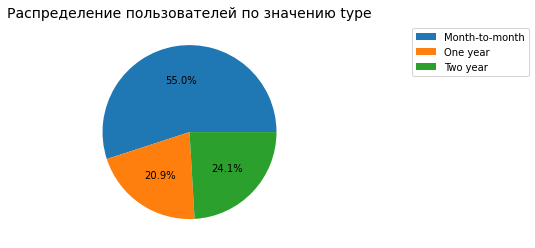

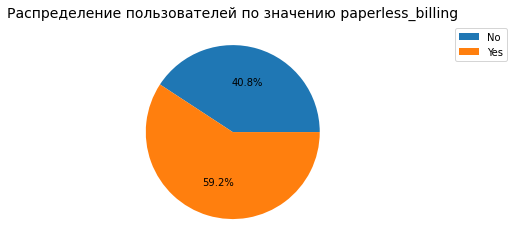

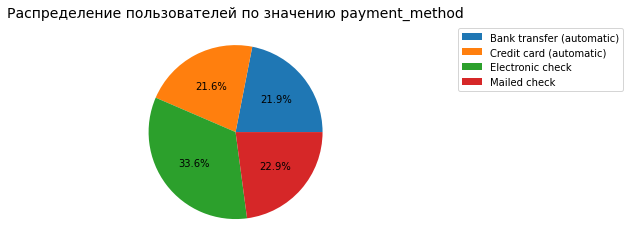

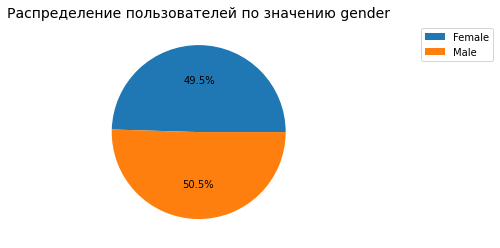

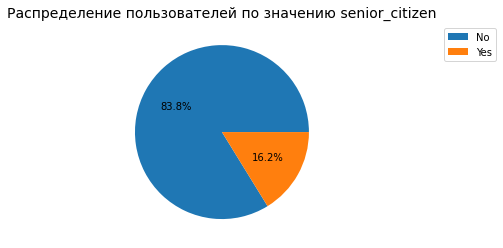

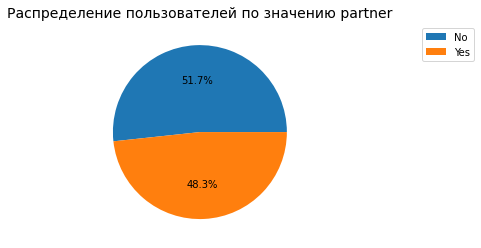

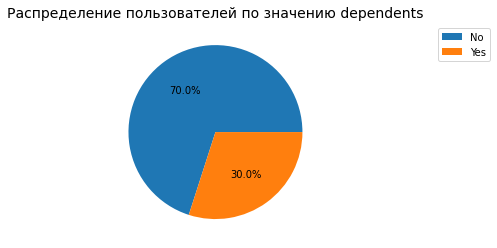

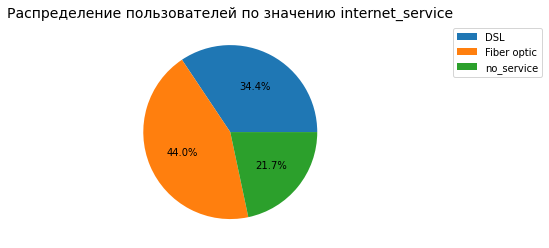

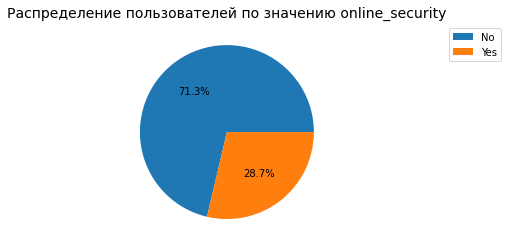

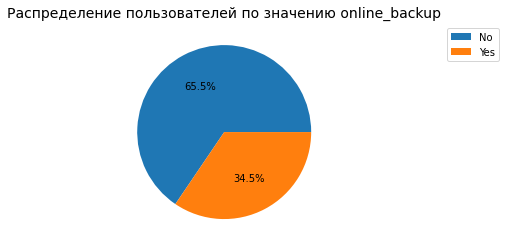

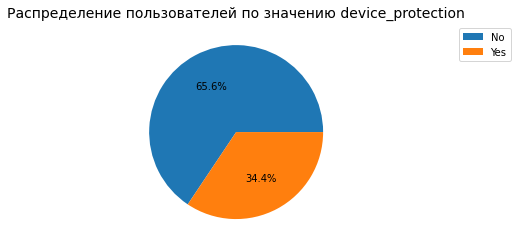

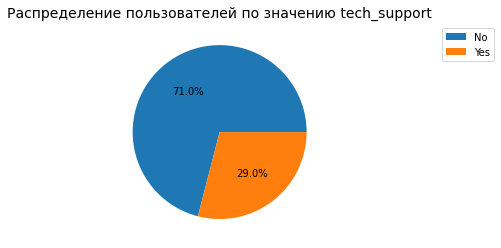

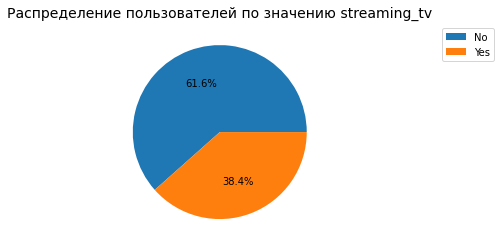

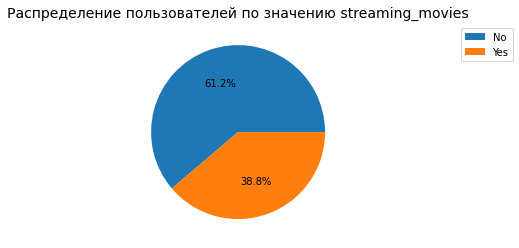

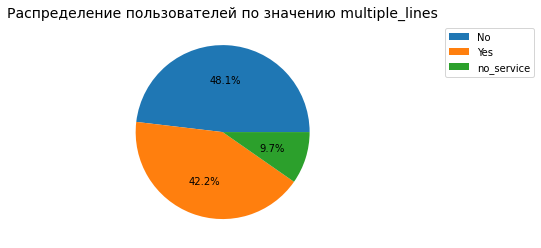

<Figure size 432x288 with 0 Axes>

In [39]:
#выведем круговые диаграммы по категориальным признакам 
for column in  data.drop(['target'],axis=1).select_dtypes(exclude='number').columns.tolist():
    pie(data,column)
    plt.subplots_adjust(wspace=0.5,hspace = 0.5);

 - Клиенты предпочитают платить ежемесячно - 55% всех договоров, за год и 2 вперед - примерно одинаково по 21-24%.
 - Безбумажный способ расчетов преобладает (59%) над бумажным,
 - Типы платежей имею примерно одинаковую долю, кроме типа платежа "электронный чек" - доля выше - 34%.
 - Распределение в разрезе пола практически одинаковое,
 - В данных преобладают покупатели-не пенсионеры(84%),
 - Наличие/отсутствие супруга - распределение также практически одиинаковое,
 - Наличие/ отсутствие детей - 30 на 70%.
 - Распределение в разрезе типа подключения к интернету- чуть больше оптоволокно (44%), чем телефонное(34%), по остальным услуга не предоставляется,
 - Около 71% из представленных в файле клиентов (в т.ч.те кто в принципе не пользуется интернетом) предпочитают не покупать услугу по блокировке опасных сайтов,29% да,
 - Не платят за услугу облачного хранения 66% от всех (в т.ч.те кто в принципе не пользуется интернетом),34.% - платят,
 - Аналогично предыдущему распределение в части оплаты  за антивирус,
 - Услугами поддержки не пользуется 71% всех пользователей (в т.ч.те кто в принципе не пользуется интернетом), 29% - пользуются,
 - Услугами стримингового телевидения и каталогом фильмов пользуются одинаковое кол-во клиентов - 61-62%,
 - Анализ признака подключение признака к нескольким одновременно: распределение по подключенным и нет пракически одинаковое - по 42 и 48 соответственно%, по 10% не пользуется услугами телефонии.
 
Отдельно рассмотрим распределение по целевому признаку 

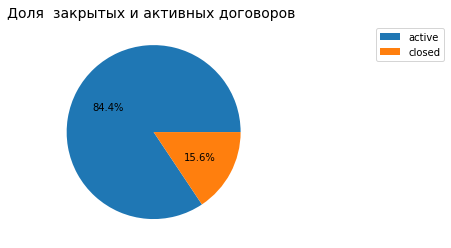

In [40]:
plt.pie(data.groupby('target')['target'].count(), autopct='%.1f%%', radius=1);
plt.legend(labels=data['target'].unique(),loc='upper left', bbox_to_anchor=(1.5, 1.0));
plt.title('Доля  закрытых и активных договоров ',fontsize=14)
plt.show()

Распределение целевого признака крайне несбалансированно - доля активных договоров в 5.4 раза выше, чем закрытых. Необходимо учесть данный факт при обучении моделей.

Проведем анализ распределения количественных признаков

In [41]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,"7,043.00",64.76,30.09,18.25,35.50,70.35,89.85,118.75
total_charges,"7,043.00","2,115.31","2,112.74",0.00,436.75,"1,343.35","3,236.69","9,221.38"
duration,"7,043.00",898.56,683.13,0.00,276.00,761.00,"1,461.00","2,314.00"


 - Месячный платеж в диапазоне от 18.25 до 118.75,средний платеж в месяц составляет 70.35, медианное же значение 64.76.
 - Общие расходы в диапазоне от 0(только что заключенные на момент выгрузки договора) и до 9221.38.
 - Длительность договоров в диапазоне от 0 до 2314 дней, медиана - 761 день.
 
 Значения, которые можно оценить как некорректные, аномальные- не выявлены, оценим далее на предмет выбросов 
 

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


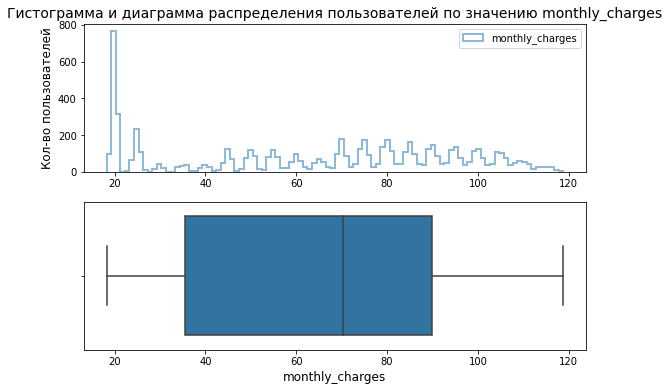

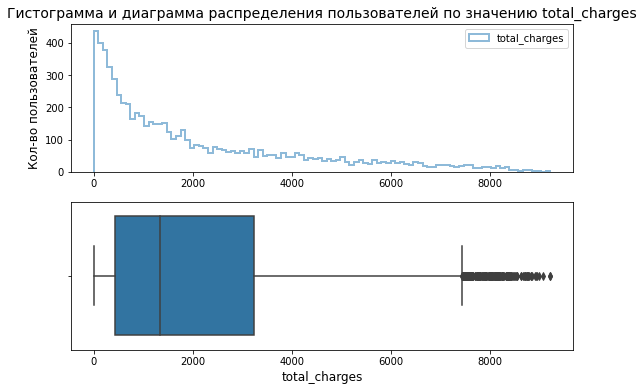

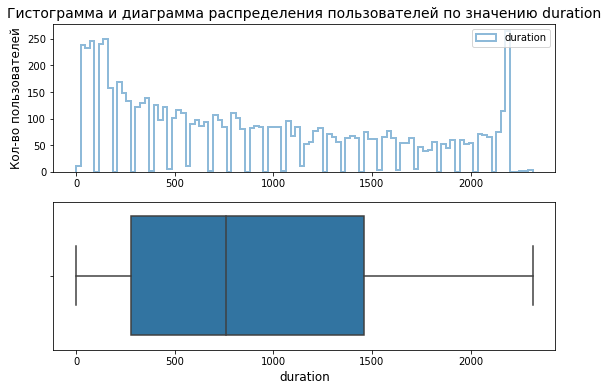

In [42]:
#выведем  диаграммы распределения и боксплот для каждого числового признака
for i in  data.select_dtypes(include='number').columns.tolist():
    hist_box(data, i);

 - Месячные платежи:распределение не является нормальным, наиболее частое значение составляет порядка 20 у.е., что в разы ниже медианного значения, выбросы отсутствуют.
 - общие расходы: распределение не является нормальным,с длинным хвостом справа, с ростом значения общих расходов кол-во таких клиентов снижается. Значения свыше 7400 оцениваются как выбросы - далее оценим насколько много таких значений,
 - длительность договора: распределение также не является нормальным, выбросы согласно боксплота отсутствуют.

In [43]:
#посчитаем долю выбросов и каким значениям длительности они соответствуют, чтобы убрать аномалии
print(f'Доля выбросов порядка:{round(len(data.query("total_charges>7400"))*100/7043,1)}%\n')
print(data.query("total_charges>7400")[['total_charges','duration']].sort_values(by='total_charges',ascending=False))

Доля выбросов порядка:2.9%

             total_charges  duration
customer_id                         
2889-FPWRM        9,221.38      2314
0675-NCDYU        9,218.88      2191
8263-QMNTJ        9,068.36      2191
0017-IUDMW        8,998.27      2191
6859-QNXIQ        8,957.52      2191
...                    ...       ...
6994-FGRHH        7,430.50      2132
2234-XADUH        7,430.40      2191
5804-HYIEZ        7,423.50      2132
2789-CZANW        7,412.16      1949
0727-BNRLG        7,411.64      2102

[201 rows x 2 columns]


Максимальным значениям общих расходов соответствуют максимальные значения длительности контрактов, поэтому утверждать, что данные выбросы являются аномалиями нельзя.

**Вывод по анализу распределения**:

 - проведен анализ распределения категориальных и количественных признаков:
   - категориальные:
     - Клиенты предпочитают платить ежемесячно - 55% всех договоров, за год и 2 вперед - примерно одинаково по 21-24%.
     - Безбумажный способ расчетов преобладает (59%) над бумажным,
     - Типы платежей имею примерно одинаковую долю, кроме типа платежа "электронный чек" - доля выше - 34%.
     - Распределение в разрезе пола практически одинаковое,
     - В данных преобладают покупатели-не пенсионеры(84%),
     - Наличие/отсутствие супруга - распределение также практически одиинаковое,
     - Наличие/ отсутствие детей - 30 на 70%.
     - Распределение в разрезе типа подключения к интернету- чуть больше оптоволокно (44%), чем телефонное(34%), по остальным услуга не предоставляется,
     - Около 71% из представленных в файле клиентов (в т.ч.те кто в принципе не пользуется интернетом) предпочитают не покупать услугу по блокировке опасных сайтов,29% да,
     - Не платят за услугу облачного хранения 66% от всех (в т.ч.те кто в принципе не пользуется интернетом),34.% - платят,
     - Аналогично предыдущему распределение в части оплаты  за антивирус,
     - Услугами поддержки не пользуется 71% всех пользователей (в т.ч.те кто в принципе не пользуется интернетом), 29% - пользуются,
     - Услугами стримингового телевидения и каталогом фильмов пользуются одинаковое кол-во клиентов - 61-62%,
     - Анализ признака подключение признака к нескольким одновременно: распределение по подключенным и нет пракически одинаковое - по 42 и 48 соответственно%, по 10% не пользуется услугами телефонии.
   - количественные:
     - Месячный платеж в диапазоне от 18.25 до 118.75,средний платеж в месяц составляет 70.35, медианное же значение 64.76.
     - Общие расходы в диапазоне от 0(только что заключенные на момент выгрузки договора) и до 9221.38.
     - Длительность договоров в диапазоне от 0 до 2314 дней, медиана - 761 день.
     - Распределение количественных признаков не является "нормальным", аномалии отсутствуют. По общим расходам присутствуют выбросы в виде максимальных значений (свыше 7400), их доля менее 3%.
 - распределение целевого признака крайне несбалансированно - доля активных договоров в 5.4 раза выше, чем закрытых. Необходимо учесть данный факт при обучении моделей


### Портрет  "ушедшего" клиента

Проведем сравнительный анализ категориальных признаков по активным и по закрытым договорам

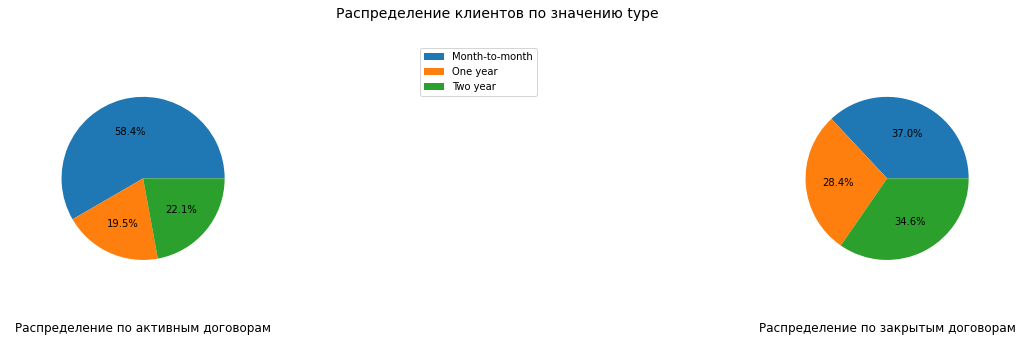

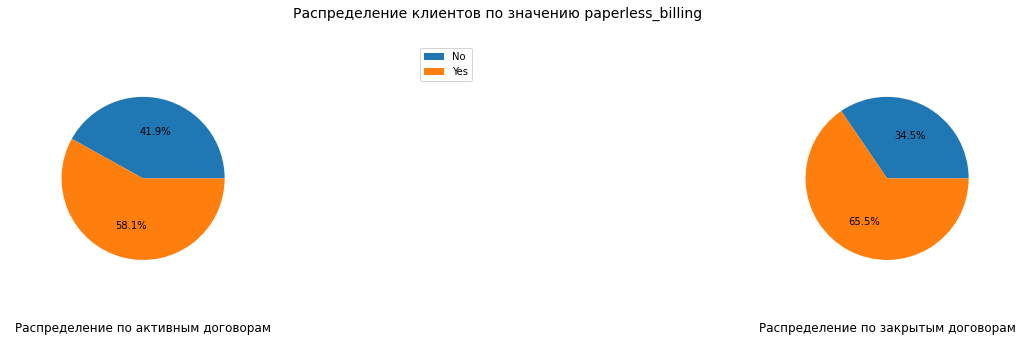

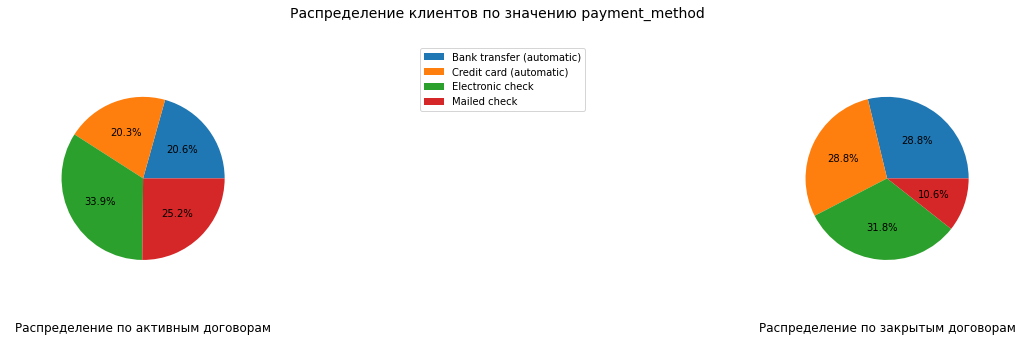

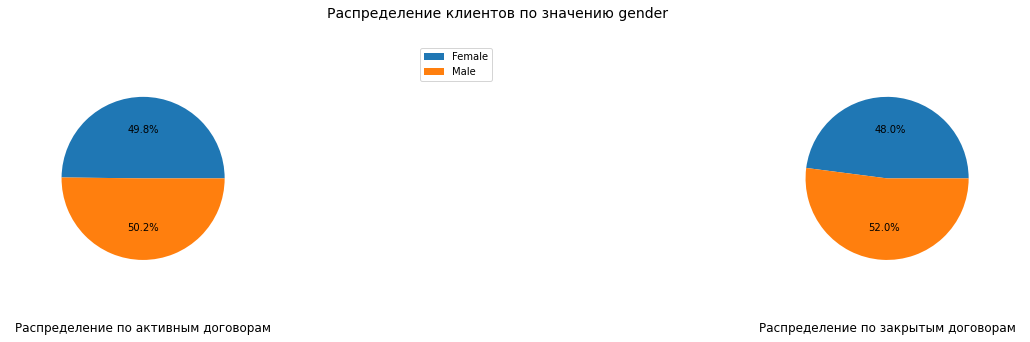

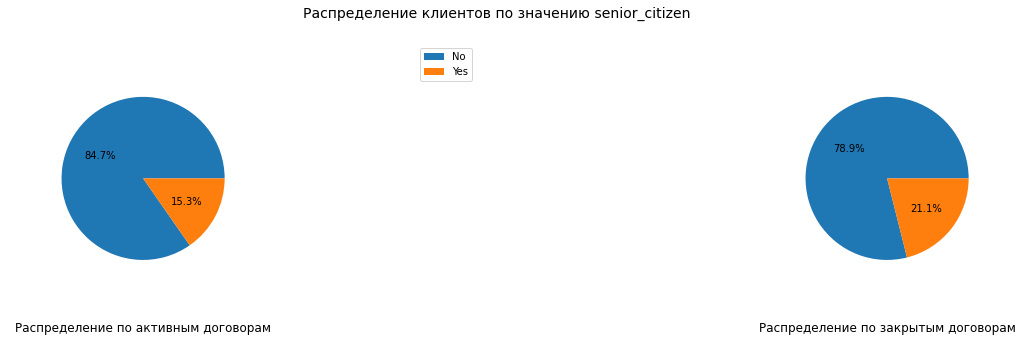

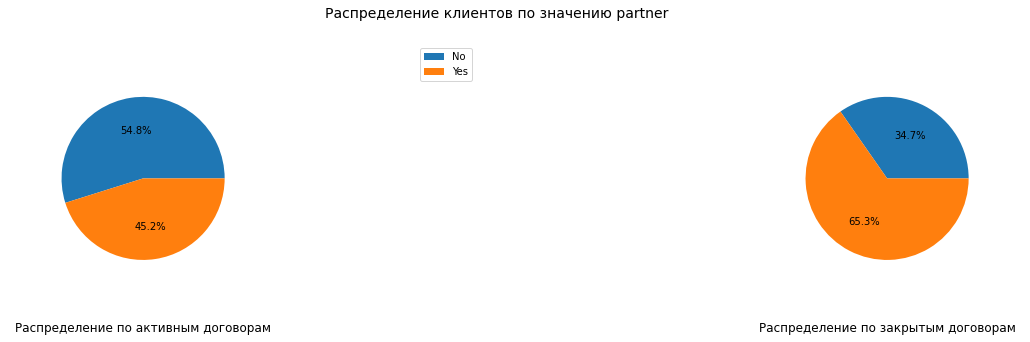

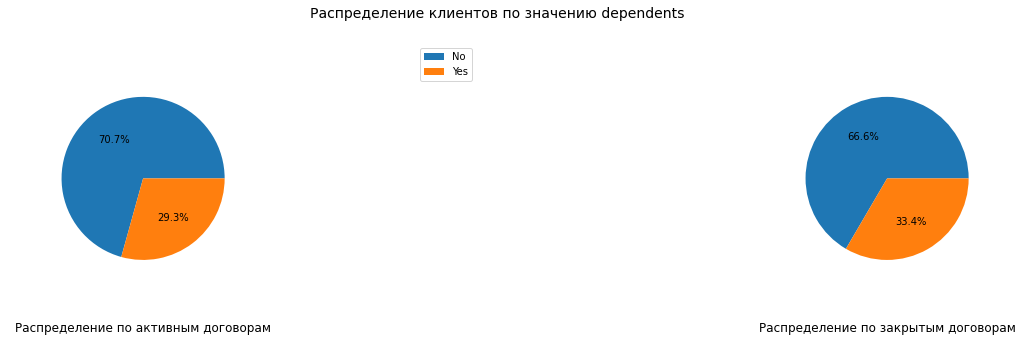

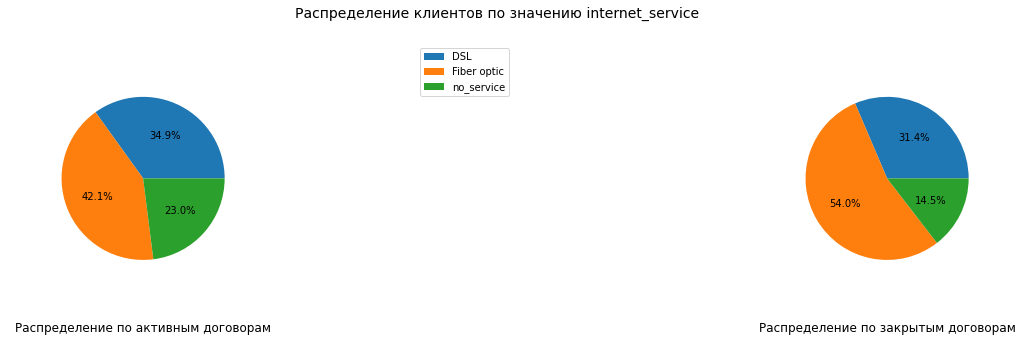

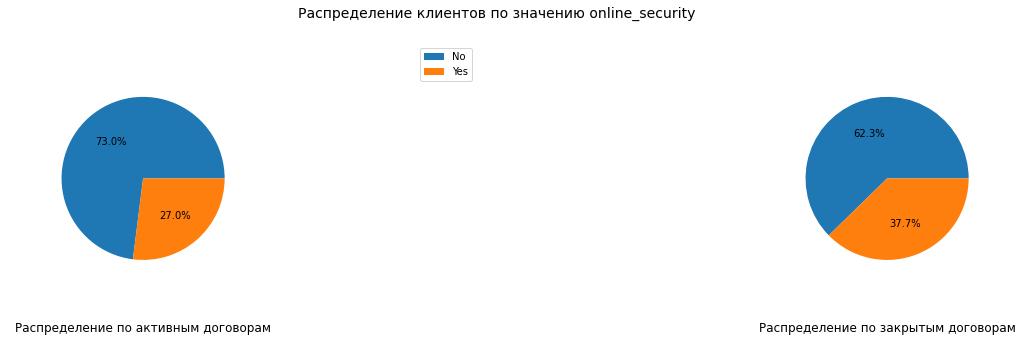

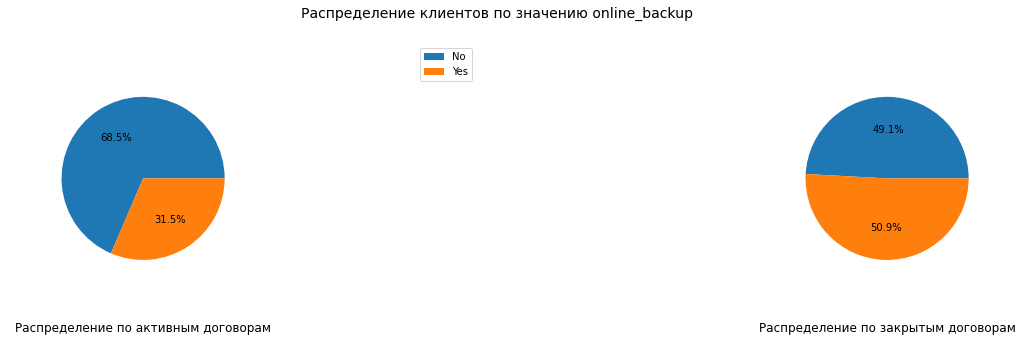

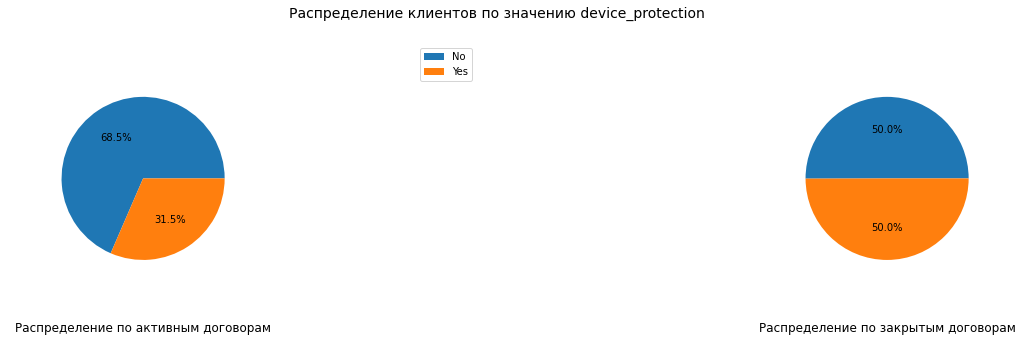

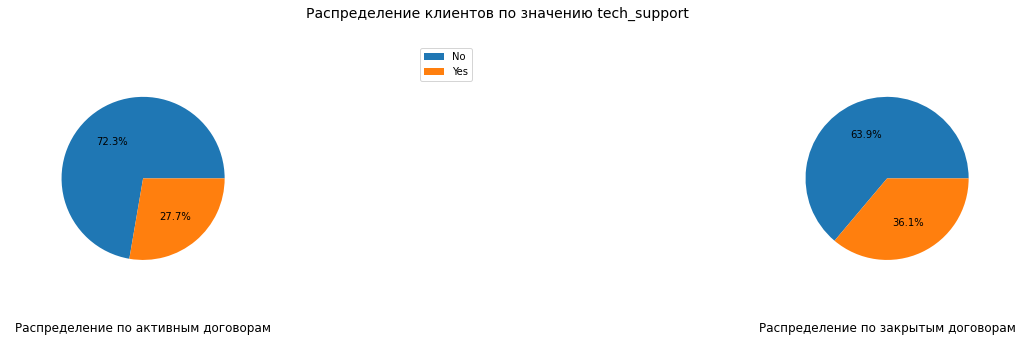

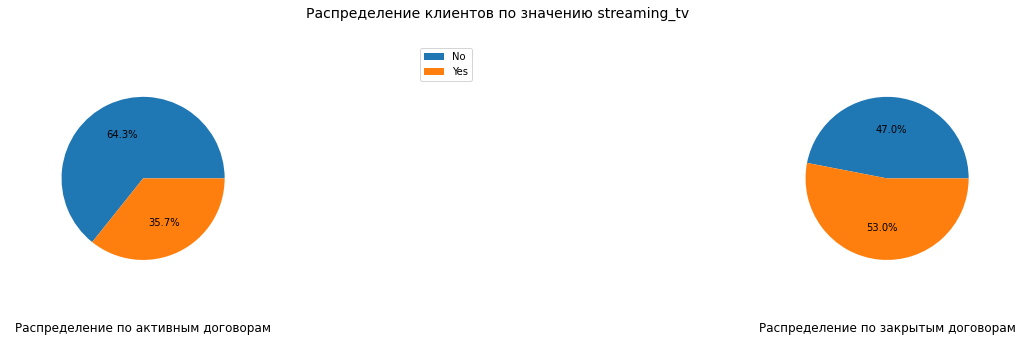

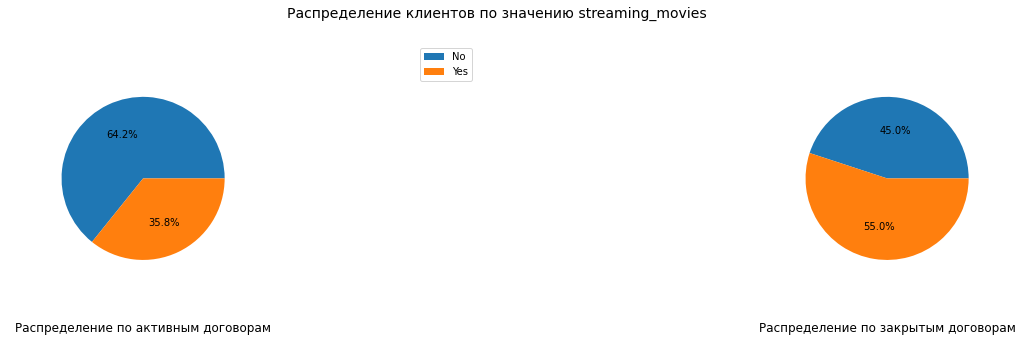

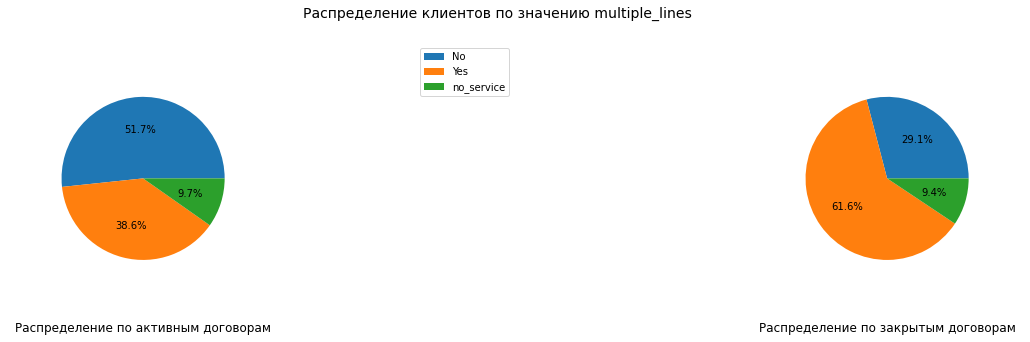

In [44]:
#выведем круговые диаграммы для активных и закрытых договоров
for column in  data.drop(['target'],axis=1).select_dtypes(exclude='number').columns.tolist():
    pie_1(data.query('target=="active"'),data.query('target=="closed"'),column)

Отличие клиентов с "закрытыми" договорам по сравнению с "активными":
- Распределение данных по признаку тип оплаты: клиенты по закрытым договорам в меньшей степени предпочитали платить каждый месяц, в то время как доля оплаты за год и за 2 года у таких клиентов выше,
- Доля оплаты электронным способом чуть выше,
- Разбиение по типам оплат отличается, из наиболее заметного - в 2.5 раза меньше оплат через почту,
- Разбивка в разрезе пола практически не отличается,
- Распределение по признаку является ли клиент пенсионером -  несущественно отличается,
- Доля женатых/замужних клиентов выше на 20%,
- По признаку наличие детей разница несущественная,
- Клиент чаще предпочитают оптоволоконное покрытие, доля не имеющих услугу интернет немного меньше,
- Чуть в большей степени пользуются услугами блокировки опасных сайтов,
- На 19% чаще предпочитают услуги облачного хранилища и антивируса,
- На 8% чаще пользуются услугой выделенной службы поддержки,
- На 16% чаще пользуются услугами стримингового телевидения и каталога фильмов,
- В 1,5 раза чаще пользуются услугой подключения телефона к нескольким линиям.

Оценим распределение количественных признаков в разрезе активных и закрытых контрактов, учтем дисбаланс классов(осуществим нормализацию по плотности)

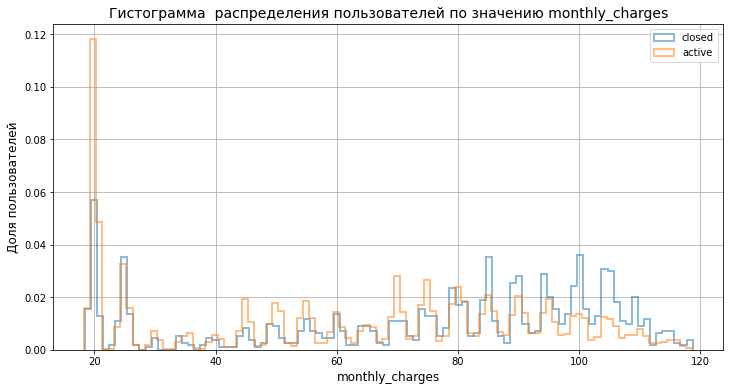

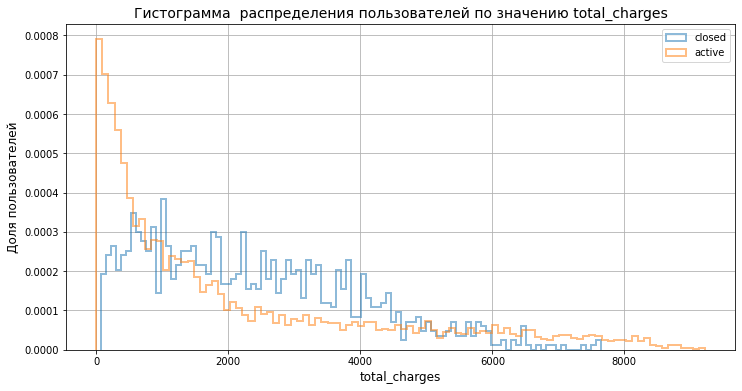

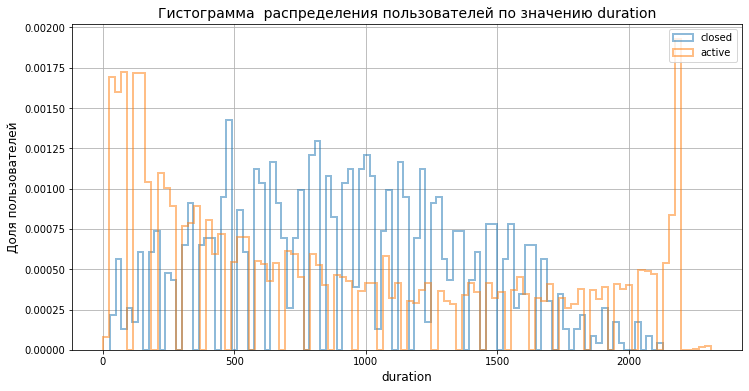

In [45]:
for column in data.select_dtypes(include='number').columns.tolist():
    hist(data,column)

 - Месячные расходы: 
   - доля клиентов по активным договорам, которые предпочитают небольшие платежи до 20 у.е., от всех клиентов с активными договорами почти в 2 раза выше, чем аналогичных клиентов с закрытыми договорами,
   - и в целом по платежам до 80 у.е. преобладает доля клиентов с активными договорами, в то время как свыше - доли клиентов с закрытыми договорами в разы выше.
 - Общие расходы:
   - здесь также по небольшим значениям (до 500) в разы преобладают доли клиентов с активными договорами, также их доли преобладают по значениям свыше 6000, доли клиентов с закрытыми контрактами во всех закрытых контрактов выше аналогичных долей по активным контрактам по значениям свыше 500 и до 6000,
 - Длительность договора в днях:  
   - распределение долей по длительности контракта похоже на распределение долей по общим расходам:наименьшим и наибольшим значениям долей соответствуют доли клиентов в активных договорах, доля клиенов в закрытых преобладают в интервале от порядка 450 дней до 1650.
   
Оценим распределение также боксплотом   

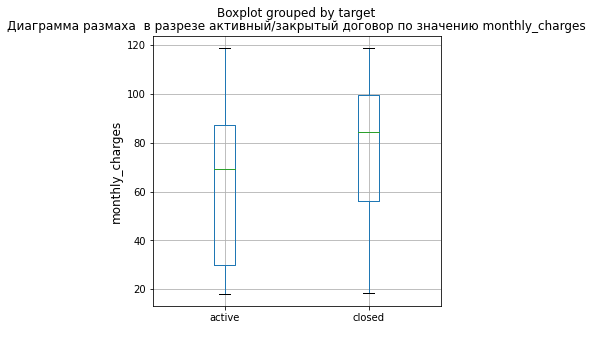

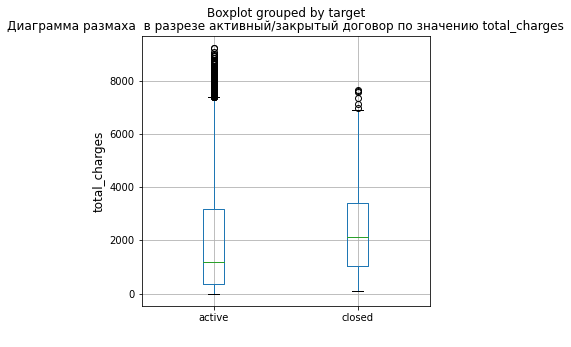

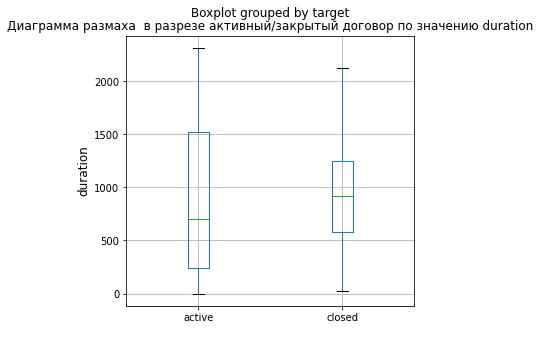

In [46]:
#выведем  диаграммы размаха для каждого числового признака
for i in  data.select_dtypes(include='number').columns.tolist():
    boxplot(data,i);

Боксплот подтверждает сделанные выше выводы при анализе гистограмм:
 -  месячные расходы: медианное значение по закрытым договорам выше, чем по активным, обе границы для 1-го и 3-го квартиля по закрытым договорам выше, чем по активным.
 - общие расходы: аналогично месячным расходам, при этом медианное значение по закрытым договорам (свыше 2000) чуть ли не  в 2 раза выше, чем по активным (порядка 12000-13000), но максимальные значения по общим расходам, которые оцениваются как выбросы, при этом по клиентам с активными договорами,
 - длительность договора: медиана по закрытым договорам выше, при этом половина всех таких клиентов плотнее сосредоточены в интервале от 600 до 1250 дней.
 
Дополнительно визуализируем распределение по целевому признаку в виде парных графиков 

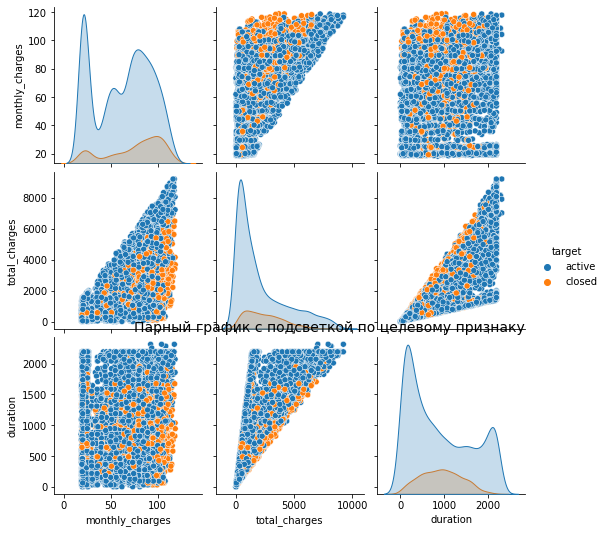

In [47]:
#выведем матрицу парных графиков для количественных признаков с подсветкой признака увольнение
sns.pairplot(data,hue = 'target')
plt.title('Парный график с подсветкой по целевому признаку', fontsize=14,loc='right')
plt.show()

 - прослеживается высокая и прямая зависимость между общими расходами и длительностью, между общими расходами и месячными платежами - что логично, т.к. общие расходы в целом складываются как произведение месячного платежа и длительность договора (грубо, без учета изменения месячного платежа),
 - для закрытых контрактов преобладают более высокие месячные платежи, значения плотно располагаются у отметки свыше 85,
 - наименее длительным и наиболее длительным договорам соответствуют активные договора, в то время как для закрытых длительность договоров находится в диапазоне до 1700 в целом.

**Портрет "ушедшего" клиента**:

- в первую очередь его отличают количественые признаки:
   - такой клиент в среднем имеет более высокие месячные платежи- свыше 85 и общие расходы,
   - длительность договоров по таким клиентам не превышает 1700 дней.
- отличие по категориальным признакам не такое существенное, по совокупности опять приводит к более высоким месячным платежам:      
  - тип оплаты: в меньшей степени предпочитает платить каждый месяц, в то время как доля оплаты за год и за 2 года у таких клиентов выше,
  -  в 2.5 раза меньше оплат через почту,
  - Доля женатых/замужних клиентов выше на 20%,
  - Клиент чаще предпочитают оптоволоконное покрытие,
  - На 19% чаще предпочитают услуги облачного хранилища и антивируса,стримингового телевидения и каталога фильмов,
  - Чаще пользуются услугой выделенной службы поддержки,
  - В 1,5 раза чаще пользуются услугой подключения телефона к нескольким линиям.
  

### Корреляционный анализ

Проведем корреляционный анализ признаков

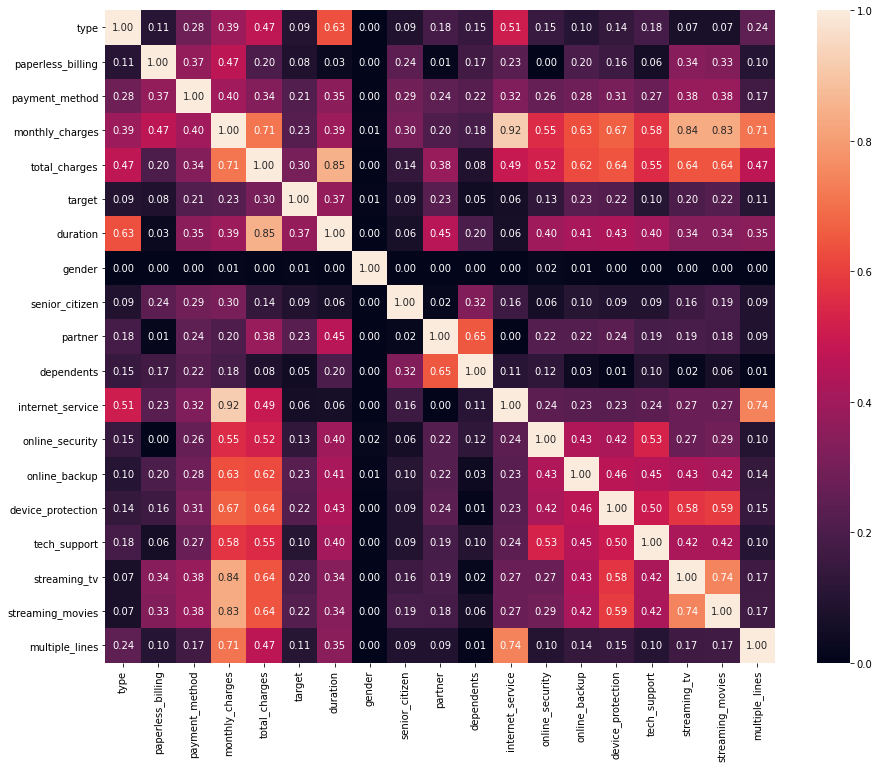

In [48]:
#построим тепловую матрицу  корреляции
fig, ax = plt.subplots(figsize=(15, 12));
sns.heatmap(
    data.phik_matrix(
    interval_cols =['monthly_charges','total_charges', 'duration']
),
ax=ax, annot=True,fmt='.2f'
);

 - Присутствует высокая корреляция между месячными платежами и интернет-услугами(от 0.55 до 0.92), 
 - Полностью отсутствует корреляция признака пол со всеми остальными признаками,
 - Целевой признак больше всего коррелирует с длительностью контракта (0.37), общими расходами (0.3),месячными платежами(0.23),наличием супруга(0.23), с рядом допинтернет услуг также заметная корреляция.
 - Мультиколлинеарность присутствует между общими расходами и длительностью договора, что логично: чем больше срок, тем больше общие расходы.
 
Для нашей модели необходимо:
 - удалить признак "пол" - практически полностью отсутствует корреляция со всеми признаками,
 - удалим признак "общие расходы" из-за мултиколлинеарности данного признака с признаком длительностьи контракта : поскольку корреляция длительности и таргета выше, то оставим признак длительность договора, а общие расходы удалим.  
 
Удалим указанные выше признаки для обучения модели 

In [49]:
data = data.drop(['total_charges','gender'],axis=1)

Повторно построим тепловую матрицу корреляции 

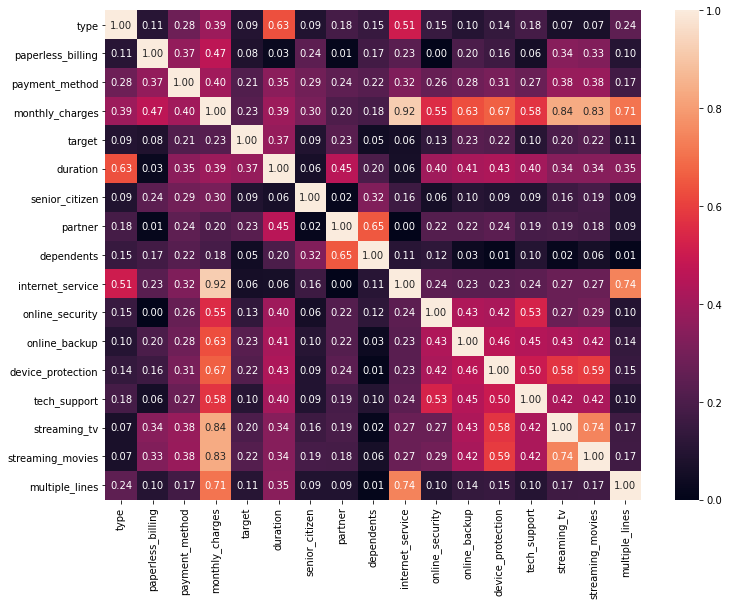

In [50]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(12, 9));
sns.heatmap(
    data.phik_matrix(
    interval_cols =['monthly_charges','duration']
),
ax=ax, annot=True,fmt='.2f'
);

Признаки с отсутствующей/практически отсутствующей с таргетом корреляцией, как и мультиколлинеарный количественный признак, удалены.

### Общий вывод

Проведен исследовательский анализ и предобработка объединенного датафрейма:
 - предобработка: заполнены появившиеся после объединения пропуски в столбцах с интернет-услугами/телефонии новым значение 'unknown', поскольку наличие/отсутствие данных услуг неизвестно,
 - проведен анализ распределения признаков как во всем объединенном датафрейме, так и в разрезе активных/закрытых контрактов,
 - получен портрет "ушедшего" клиента:
   - в первую очередь его отличают количественные признаки:
     - такой клиент в среднем имеет более высокие месячные платежи- свыше 85 и общие расходы,
     - длительность договоров по таким клиентам не превышает 1700 дней.
   - отличие по категориальным признакам не такое существенное, по совокупности опять приводит к более высоким месячным платежам
 - проведен корреляционный анализ, по результатам которого  были исключены мултиколлинеарный количественный признак, а также исключен признак с отсутствующей корреляцией с целевым признаком.   



## Подготовка данных

Подготовим данные к обучению.
После удаления столбца с идентификаторами и ряда столбцов в рамках анализа коллинеарности моргли появиться новые дубликаты строк - от них необходимо избавиться. В целом,удалять дубликаты целесообразно только из тренинговой выборки, а не тестовой, но если таких дубликатов немного, то удалим их до разбивки на тренинговую и тестовую

In [51]:
#вывявим дубликаты
data.duplicated().sum()

40

In [52]:
#удалим дубликаты
data = data.drop_duplicates()
#закодируем целевой признак вручную для простоты
data['target'] = data['target'].apply(lambda x: 1 if x=="closed" else 0)

Далее подготовим тренинговую и тестовую выборки: отдельно для бустинговой моделей CatBoost(поскольку для нее не нужно отдельно обрабатывать категориальные признаки, она это делает сама) и для прочих. Для небустинговых моделей проведем масштабирование количественных признаков и обработаем категориальные. При разбиении учтем, что целевой признак несбалансирован (стратифицируем его).

Сначала выделим целевой признак и прочие, разобьем выборку на тестовую и тренинговую для небустинговых моделей 

In [53]:
#выделим целевой признак и прочие, разобьем выборку на тестовую и тренинговую
X = data.drop(['target'],axis=1)
y = data['target']

X_train,X_test,y_train,y_test = train_test_split( 
                                     X,
                                     y,
                                     stratify = y,
                                     test_size = 0.25,
                                     random_state = RANDOM_STATE
    )
X_train.head(1)

,type,paperless_billing,payment_method,monthly_charges,duration,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,
5243-SAOTC,Month-to-month,Yes,Bank transfer (automatic),79.85,1645,No,No,No,Fiber optic,No,Yes,No,No,No,No,Yes


In [54]:
#выделим количественные и категориальные признаки
num_col = X_train.select_dtypes(include='number').columns.tolist()
cat_col = X_train.select_dtypes(exclude='number').columns.tolist()

Для небустинговых моделей будем инициировать модель путем создания пайпа, для чего создадим для него шаг с типовой предобработкой категориальных и количественных признаков, к которому будем обращаться в пайпе.

In [55]:
#предобработка данных
data_preprocessor = ColumnTransformer([
       ('ohe',OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), cat_col),
       ('num', StandardScaler(), num_col)
      ],
    remainder='passthrough')

Выделим тренинговую и тестовую выборки для бустинговых моделей

In [56]:
#выделим целевой признак и прочие
y_boost = data['target']
X_boost = data.drop(['target'],axis=1)

#переведем категориальные признаки в тип category, который требуется для GBM
X_boost[cat_col] = X_boost[cat_col].astype('category')


#сплит
X_boost_train,X_boost_test,y_boost_train,y_boost_test = train_test_split( 
                                     X_boost,
                                     y_boost,
                                     stratify = y_boost,
                                     test_size = 0.25,
                                     random_state = RANDOM_STATE
    )
X_boost_test.head(1)

,type,paperless_billing,payment_method,monthly_charges,duration,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,
7375-WMVMT,Two year,Yes,Credit card (automatic),95.50,2163,Yes,Yes,No,Fiber optic,No,Yes,Yes,Yes,No,Yes,No


**Вывод по подготовке данных**:

 - произведена подготовка данных для дальнейшего обучения моделей:удалены дубликаты, произведена разбивка на тренинговую/тестовые выборки отдельно для бустинговой модели CatBoost и небустинговых моделей, подготовлена функция для обучения моделей

## Обучение моделей машинного обучения

Обучим несколько моделей: логрег, несколько "деревьев" и бустинговая модель CatBoost.
Поскольку в наших данных целевой признак несбалансирован, то качество  модели будет оценивать метрикой AUC-ROC, которая нечувствительна к дисбалансу классов.

По итогу обучения выявим гиперпараметры модели  с наиболее высокой метрикой качества

### Логистическая регрессия

In [57]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_logreg = Pipeline([
('preprocessor', data_preprocessor),
('model', LogisticRegression(class_weight='balanced',random_state=RANDOM_STATE,penalty = 'l1'))        
     ])                          

In [58]:
# словарь для модели LogisticRegression()
parameters_logreg = {
    'model__solver': ['liblinear', 'saga'],
        'model__C': [0.1,1,10,100], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    }

# обучим модели и получим лучшую модель, ее гиперпараметры и значение метрики на кросс-валидации
model_logreg = training(pipe_logreg,parameters_logreg,boosting = False)  

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the n

Значение AUC-ROC на кросс-валидации: 0.75
{'model__C': 1, 'model__solver': 'liblinear', 'preprocessor__num': 'passthrough'}
Время на обучение модели- 1.34 секунд


Модель показала метрику при кросс-валидации 0.75.

### Модель RandomForestClassifier

In [59]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_rendfor = Pipeline([
('preprocessor', data_preprocessor),
('model', RandomForestClassifier(random_state=RANDOM_STATE))        
     ])  

In [60]:
# словарь для модели RandomForestClassifier() - время добавить и все в таблицу
parameters_rendfor = {
    'model__max_depth': [1, 100, 200],
'model__n_estimators': [1, 100, 200], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    }
# обучим модели и получим лучшую модель, ее гиперпараметры и значение метрика на кросс-валидации
model_rendfor = training(pipe_rendfor, parameters_rendfor,boosting = False) 

Значение AUC-ROC на кросс-валидации: 0.79
{'model__max_depth': 100, 'model__n_estimators': 200, 'preprocessor__num': RobustScaler()}
Время на обучение модели- 0.9 секунд


Модель показала метрику при кросс-валидации 0.79

### Модель DecisionTreeClassifier

In [61]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_dtc = Pipeline([
('preprocessor', data_preprocessor),
('model', DecisionTreeClassifier(random_state=RANDOM_STATE))        
     ])

In [62]:
# словарь параметров для модели DecisionTreeClassifier()
parameters_dtc = {
        'model__max_depth': range(2, 10),
        'model__max_features': range(10, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']  
    }
# обучим модели и получим лучшую модель, ее гиперпараметры и значение метрика на кросс-валидации
model_dtc = training(pipe_dtc, parameters_dtc,boosting = False) 

Значение AUC-ROC на кросс-валидации: 0.79
{'model__max_depth': 6, 'model__max_features': 14, 'preprocessor__num': MinMaxScaler()}
Время на обучение модели- 0.04 секунд


Модель показала метрику при кросс-валидации 0.79.

### Модель градиентного бустинга CatBoostClassifier

In [63]:
# инициируем модель CatBoostClassifier, в которой учтем дисбаланс классов
classes = np.unique(y_boost_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_boost_train)
class_weights = dict(zip(classes, weights))

model_clf = CatBoostClassifier(class_weights=class_weights,logging_level='Silent')       

In [64]:
# словарь параметров для модели CatBoostClassifier()
parameters_catboost = {
        'max_depth': [3,4,5],
       'n_estimators':[500,1000],
       'learning_rate': [.01, 1]  
    }
# обучим модели и получим лучшую модель, ее гиперпараметры и значение метрика на кросс-валидации
model_catboost = training(model_clf, parameters_catboost) 

Значение AUC-ROC на кросс-валидации: 0.91
{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 1000}
Время на обучение модели- 5.89 секунд


Модель показала метрику при кросс-валидации 0.91. Порог для метрики учтен.

## Выбор лучшей модели

Выберем лучшую модель, исходя из наилучшей метрики качества при кросс-валидации - это бустинговая модель CatBoost. Посчитаем на ней метрику качества AUC-ROC и дополнительно Accuracy.

In [65]:
#посчитаем предсказание для целевого признака и вероятность отнесения к классу
pred_catboost = model_catboost.predict(X_boost_test)
pred_proba_catboost = model_catboost.predict_proba(X_boost_test)

print('AUC-ROC для  модели бустинга на тесте : ',round(roc_auc_score(y_boost_test, pred_proba_catboost[:, 1]),2))
print('Показатель Accuracy для  модели бустинга на тесте:', round(accuracy_score(y_boost_test, pred_catboost),2)) 

AUC-ROC для  модели бустинга на тесте :  0.91
Показатель Accuracy для  модели бустинга на тесте: 0.91


Оба значения на достаточно высоком уровне.
Интерпретируем результаты метрик

Начнем с визуализации метрики AUC-ROC, которая по сути показывает площадь под кривой ROC

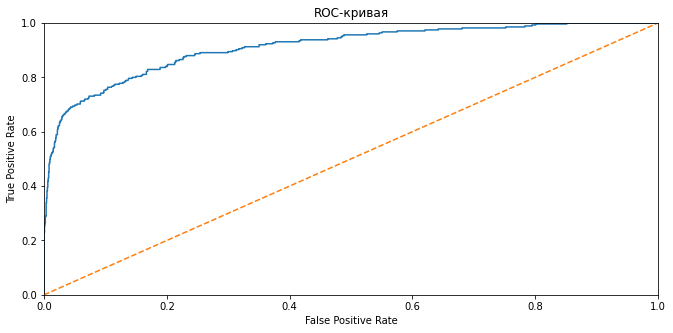

In [66]:
fpr, tpr, thresholds = roc_curve(y_boost_test, pred_proba_catboost[:, 1])
plt.figure(figsize=(11, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Площадь под кривой ROC это и есть значение AUC-ROC в зависимости от выбора порога отнесения к классу  закрытый/активный договор

Значение Accuracy на высоком уровне (помним, что по умолчанию модель для определения класса берет порог в 0.5), но  целевой признак несбалансирован и поэтому доля ложноположительных и ложноотрицательных значений может существенно отличаться.  Построим матрицу ошибок для оценки 

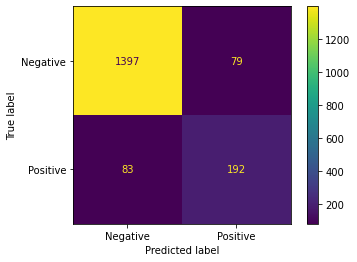

In [67]:
# Матрица ошибок
cm = confusion_matrix(y_boost_test, pred_catboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()

Анализ матрицы при пороге отнесения к классам 0.5 показывает следующее:
- протестированная модель  предсказывает большую часть класса 0 ( 'Negative' - активный договор) - доля ошибок 5.4%. 
- при этом предсказание класса 1 ('Positive' - закрытый договор) намного хуже - доля ошибок 30%,т.е. около трети всех предсказаний.

Если нам важнее не допускать ошибку 2-го рода(не упустить "уходящего" клиента), то нужно оптимизировать метрику recall, а если 1-го рода (мы дадим скидки,бонусы клиенту, а он не собирался уходить) - то precision. 

Оценим при каких порогах отнесения к классам 0 и 1 метрики recall и precision принимают оптимальное значение и какое при это  значение  accuracy

In [68]:
#объединим в одну предсказание класса и фактическое значение класса
y = pd.DataFrame(zip(y_boost_test, pred_proba_catboost[:, 1]),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

#разобьем интвервал с предсказанием класса на несколько значений
thresholds = np.linspace(.01, 1, 100)

# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавим столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    y['y_pred_'+str(i)] = y['y_proba'].apply(lambda x: 0 if x<i else 1)
        

Далее посчитаем значения метрик recall,precision и  accuracy для каждого порога

In [69]:
#зададим расчет метрик для каждого порога
accuracy_list = []
precision_list = []
recall_list = []

for i in columns:
    accuracy = accuracy_score(y['y_valid'],y[i])
    accuracy_list.append(accuracy)
    precision = precision_score(y['y_valid'],y[i])
    precision_list.append(precision)
    recall = recall_score(y['y_valid'],y[i]) 
    recall_list.append(recall)

#объединим все метрики в одну таблицу,отфильтруем по значению порога     
metrics = pd.DataFrame(zip(thresholds,accuracy_list, precision_list,recall_list),
             columns = ['thresholds','accuracy', 'precision','recall']).sort_values(by='thresholds')

#выведем полученную таблицу
metrics

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,thresholds,accuracy,precision,recall
0,0.01,0.69,0.33,0.91
1,0.02,0.75,0.37,0.89
2,0.03,0.78,0.41,0.88
3,0.04,0.80,0.43,0.85
4,0.05,0.81,0.45,0.84
...,...,...,...,...
95,0.96,0.91,0.92,0.45
96,0.97,0.90,0.91,0.43
97,0.98,0.90,0.93,0.39
98,0.99,0.89,0.94,0.34


Максимальные значения recall наблюдаются при манимальных порогах, в то время как precision, наоборот, растет с увеличением порога.

Визуализируем зависимость метрик от порога отнесения к классам

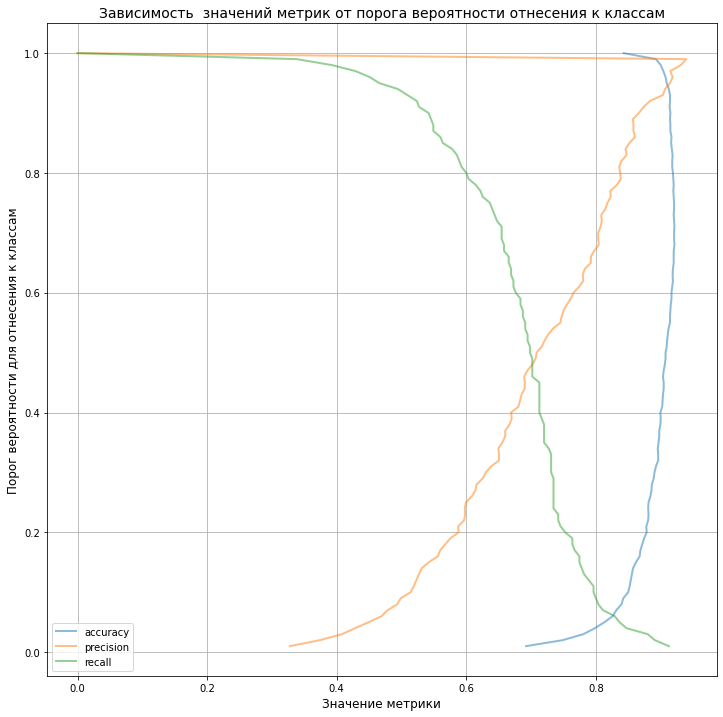

In [70]:
#построим график зависимости метрик от выбранного порога отнесения к классам
fig, ax = plt.subplots(figsize = (12, 12));
ax = plt.subplot()
for i in metrics.drop(['thresholds'],axis=1).columns:
    plt.plot(metrics[i],metrics['thresholds'],label = i,\
                                  linewidth=2,alpha=0.5);
plt.legend()
plt.grid(True)
plt.ylabel('Порог вероятности для отнесения к классам', fontsize=12);
plt.xlabel('Значение метрики', fontsize=12);
plt.title('Зависимость  значений метрик от порога вероятности отнесения к классам',fontsize=14);
plt.show()

 - Максимальное значение precision наблюдается при вероятности 0.99 - значение метрики 0.94, это значит, что при данном пороге минимизируются ошибки 1-го рода. Точность при данном пороге составляет 0.89.
 - Максимальное значение recall наблюдается при вероятности 0.01 - значение метрики 0.91, при данном пороге минимизируются ошибки 2-го рода. Точность при данном пороге составляет 0.69. Оптимальным с т.з. общей точности и recall является вероятность порядка 0.06-0.07 - значения recall и accuracy порядка 0.83.
 
 
Проведем анализ важности признаков 

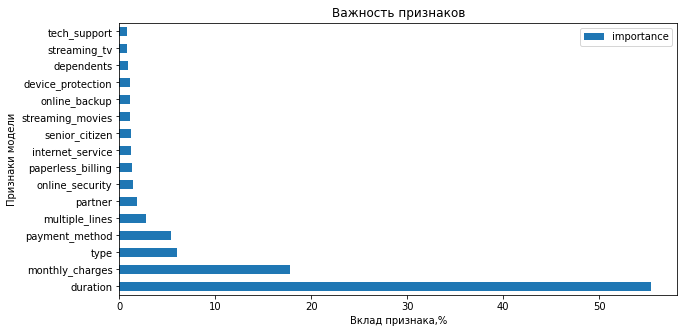

In [71]:
#вытащим признаки из модели 
feature_importance = pd.DataFrame(model_catboost.best_estimator_.feature_importances_, index=X_boost_test.columns,
    columns=['importance']
).sort_values(by='importance', ascending=False)
# визуализируем из важность
feature_importance.plot(kind='barh', figsize=(10, 5), title='Важность признаков')
plt.xlabel('Вклад признака,%')
plt.ylabel('Признаки модели')
plt.legend()
plt.show()

Как видим,наиболее важными признаками являются  длительность договора, далее с большим отрывом идут месячные платежи, далее снова с отрывом тип платежа,тип оплаты, пользование несколькими телефонными линиями, наличие супруга и пр. признаки ("важность" менее 2%).

**Вывод**:

 - наилучшую метрику при кросс-валидации показала бустинговая модель CatBoostClassifier, значение  метрики данной модели на тесте:AUC-ROC - 0.91,
 - значение Accuracy (по умолчанию порог для отнесения к классам определен в 0.5) достаточно высокое -0.91, но при данном пороге ошибки 2-го рода составляют 30% от всех предсказанных закрытых договоров. Если нам важнее не допускать ошибку 2-го рода(не упустить "уходящего" клиента), то нужно оптимизировать метрику recall(максимальна при пороге отнесения к классам 0.01, при этом accuracy всего 0.69), а если 1-го рода (мы дадим скидки,бонусы клиенту, а он не собирался уходить) - то precision(максимальна при пороге отнесения к классам 0.99, при этом accuracy составляет 0.89). 
 - для лучшей модели наиболее важными признаками являются длительность договора, далее с большим отрывом идут месячные платежи, далее снова с отрывом тип оплаты,метод оплаты, пользование несколькими телефонными линиями, наличие супруга. Совсем небольшой вклад имеют прочие признаки("важность" менее 2%).

## Общий вывод и рекомендации заказчику

**Поставлена задача по обучению модели предсказания оттока клиентов**:

 - обучено несколько моделей (линейной регрессии, 2 модели деревьев и модель градиентного бустинга), лучшую метрику ROC AUC при кросс-валидации показала модель градиентного бустинга  CatBoostClassifier с гиперпараметрами (‘learning_rate': 1, 'max_depth': 3, 'n_estimators': 1000). На тестировании данная модель имеет значение метрики ROC AUC равное 0.91, что выше требуемого в 0.85. Также данная модель имеет достаточно высокое значение Accuracy  0.91(по умолчанию порог для отнесения к классам определен в 0.5)

**Для достижения поставленной задачи было выполнено**:

 - Загружены данные из файлов.
 - Проведены исследовательский анализ и предобработка данных исходных датафреймов с информацией о договорах, персональной информацией, информация об интернет-услугах и об услугах телефонии. Из входных признаков данных с договорами были исключены признаки с датами заключения/расторжения договора  - посколько при предсказании с иными датами модель может потерять точность, но сгенерированы 2 новых признака - целевой (договор закрыт/активен) и длительность договора в днях.При предобработке выявлены некорректные типы данных (например, по только открытым договорам в общих расходах проставлен «пробел» из-за чего тип данных определяется не числовой - пробелы заменены нулями). Аномалии в числовых данных не выявлены.
 - Данные исходных таблиц объединены в одну.
 - Проведен исследовательский анализ и предобработка объединенного датафрейма:
   - предобработка: заполнены появившиеся после объединения пропуски в столбцах с типом подключения интернета/телефонии новым значение 'no_service' (значит услуги интернета/телефонии вообще не предоставляются), а по допинтернет услугам - 'no'(пропуски в данных столбцах присутствуют, если услуга подключения к интернету не предоставляется).
   - проведен анализ распределения признаков как во всем объединенном датафрейме, так и в разрезе активных/закрытых контрактов,
   - получен портрет "ушедшего" клиента:
     - в первую очередь его отличают количественные признаки:
       - такой клиент в среднем имеет более высокие месячные платежи- свыше 85 и общие расходы,
       - длительность договоров по таким клиентам не превышает 1700 дней.
       - отличие по категориальным признакам не такое существенное, по совокупности опять приводит к более высоким месячным платежам
   - проведен корреляционный анализ, по результатам которого исключен один из  мултиколлинеарных количественных признаков "общие расходы" (мультиколлинеарен с длительностью договора), а также исключен признак с минимальной корреляцией с целевым признаком - пол.
 - Подготовлены данные к использованию в обучении моделей: отдельно для бустинговых и небустинговых моделей, учтен дисбаланс классов.
 - Обучены модели машинного обучения (линейной регрессии, 2 модели деревьев и модель градиентного бустинга)
 - На основе метрики ROC AUC выбрана и протестирована лучшая модель -  CatBoostClassifier (гиперпараметры и метрики описаны выше). Для нее наиболее важными признаками являются длительность договора, далее с большим отрывом идут месячные платежи, далее снова с отрывом тип платежа,тип оплаты, пользование несколькими телефонными линиями, наличие супруга и пр. признаки ("важность" менее 2%).


На основании проведенного анализа появились следующие **рекомендации  заказчику**:

 - Метрика ROC AUC у лучшей модели достаточно высокая, при этом нужно понимать, что она оценивает совокупное качество предсказания. Помимо эффективности предсказания модели  в целом нужно также оптимизировать метрики, исходя из бизнес-цели: что важнее - минимизировать потери из-за упущения «уходящего» клиента (не допускать ошибку 2-го рода, т.е минимизировать ложноотрицательные предсказания оптимизировать метрику recall), или не получить убытки в случае предоставления промокодов/специальных условий, а клиент при этом не собирался уходить(ошибки 1-го рода - оптимизировать метрику precision). Оптимизация данных метрик производится путем подбора необходимого порога отнесения предсказания к классу закрытый или активный договор:максимальное значение precision наблюдается при пороге вероятности 0.99 - значение метрики 0.94, максимальное значение recall наблюдается при пороге вероятности 0.01 - значение метрики 0.91.
 - Наиболее важными признаками являются длительность договора и месячные платежи. Исходя из портрета  «уходящего» клиента, он в среднем имеет более высокие месячные платежи- свыше 85 и длительность договоров по таким клиентам не превышает 1700 дней: такие клиенты находятся в повышенной зоне риска разрыва контракта и при этом приносят более высокие месячные платежи, т.е.должны быть более прибыльными, поэтому  по ним в первую очередь стоит рассмотреть предоставление промокодов/спецусловий.
 - Анализ сезонности в датах закрытия контракта показал, что закрывать договора клиенты более склонны осенью и пик приходится на конец календарного года -именно в это время стоит более активно предлагать промокоды и спецусловия клиентам с высоким риском разрыва контракта.